In [1]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#https://github.com/amueller/word_cloud

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import regex as re
from collections import Counter

#So I can see multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Load the extra clean data
df = pd.read_csv('recipe_overclean.csv', sep = ",", quotechar = '"', dtype=object, index_col=0)
df["TotalIng"] = pd.to_numeric(df["TotalIng"])

In [3]:
df.sample(2)

,Website,Link,Title,TotalTime,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,TotalIng
122586,sweetcsdesigns,http://sweetcsdesigns.com/greek-chicken-souvlaki/,Greek Chicken Souvlaki,40 min,"4 chicken breasts, cut into 1-1/2 pieces""",¼ cup olive oil,¼ cup lemon juice,1 tsp dried oregano,1 tsp salt,½ tsp garlic powder,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69
122618,health,http://www.health.com/health/recipe/0,NaN,10000001054855,00.html,Greek Chicken with Angel Hair Pasta,40 min,1 pound uncooked angel hair pasta,1 tablespoon olive oil,"4 , skinless, boneless chicken breasts, halved",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63


In [4]:
#View some summary data by website
agg1 = df.groupby("Website").size()
agg2 = 76 - df.groupby('Website')[["TotalIng"]].mean()
website = pd.concat([agg1, agg2], axis=1, sort=False)
website.rename(columns={0: 'NumRecipes', 'TotalIng': 'AveNumIngr'}, inplace=True)
website

,NumRecipes,AveNumIngr
Website,,
100daysofrealfood,8,14.250000
101cookbooks,15,13.200000
101cookingfortwo,5,10.600000
12tomatoes,40,16.075000
196flavors,3,18.333333
1mrecipes,2,15.000000
247lowcarbdiner,1,11.000000
28cooks,1,14.000000
2stews,2,27.000000


In [5]:
# Summary statistic of each website's recipes
wb_topsum = website.sort_values(by='NumRecipes',ascending=False).head(20)
wb_topave = website.sort_values(by='AveNumIngr',ascending=False).head(20)

In [6]:
#View the reason we are only going to look at the top websites for the below visualization
wb_topsum
wb_topave

,NumRecipes,AveNumIngr
Website,,
tastykitchen,39387,10.129383
epicurious,33828,9.758218
foodnetwork,13957,12.386258
bonappetit,12464,10.642089
cookstr,7009,10.277786
foodrepublic,3617,11.704451
food,2429,12.484562
finedininglovers,1844,11.404555
whatsgabycooking,1161,11.171404


,NumRecipes,AveNumIngr
Website,,
balancingcinderella,1,58.000000
mannaandspice,1,42.000000
autoimmunewellness,1,41.000000
forbiddenriceblog,2,40.500000
safeeggs,1,37.000000
online,1,37.000000
link,1,36.000000
thetiffinbox,1,36.000000
culinaryorgasm-karen,1,35.000000


<Figure size 1080x720 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

Text(0.5, 1.0, 'Number of Recipes per top 20 Sites')

Text(0.5, 0, 'Website of Origin')

Text(0, 0.5, 'Number of Recipes')

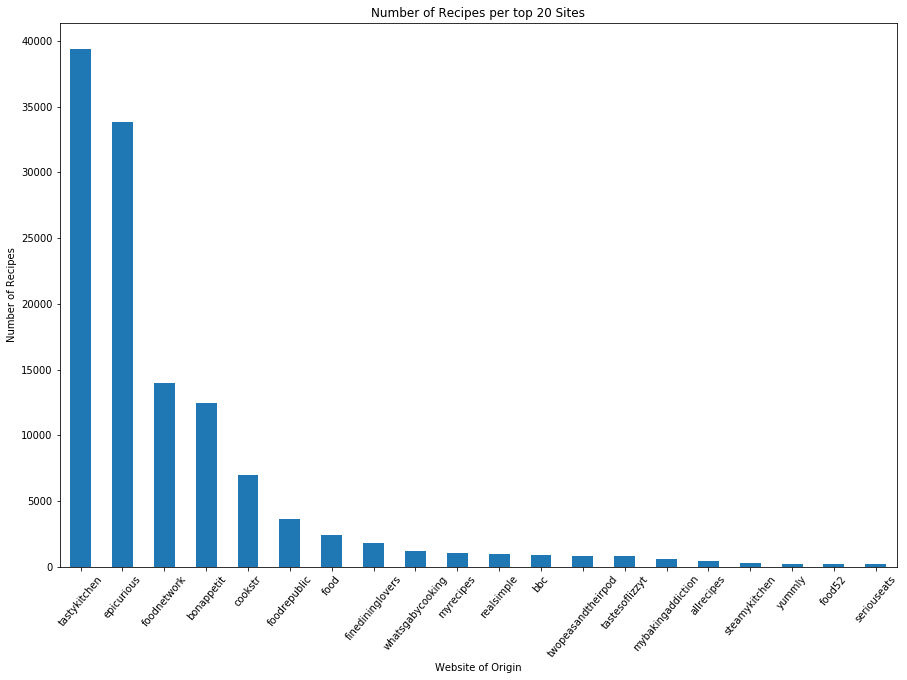

In [7]:
plt.figure(figsize=(15,10))
wb_topsum.NumRecipes.sort_values(ascending=False).plot.bar()

plt.xticks(rotation=50)
plt.title('Number of Recipes per top 20 Sites')
plt.xlabel("Website of Origin")
plt.ylabel("Number of Recipes")
plt.show()

<Figure size 1080x720 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

Text(0.5, 1.0, 'Average Number of Ingredients per Recipe in top 20 Sites')

Text(0.5, 0, 'Website of Origin')

Text(0, 0.5, 'Average Number of Ingredients')

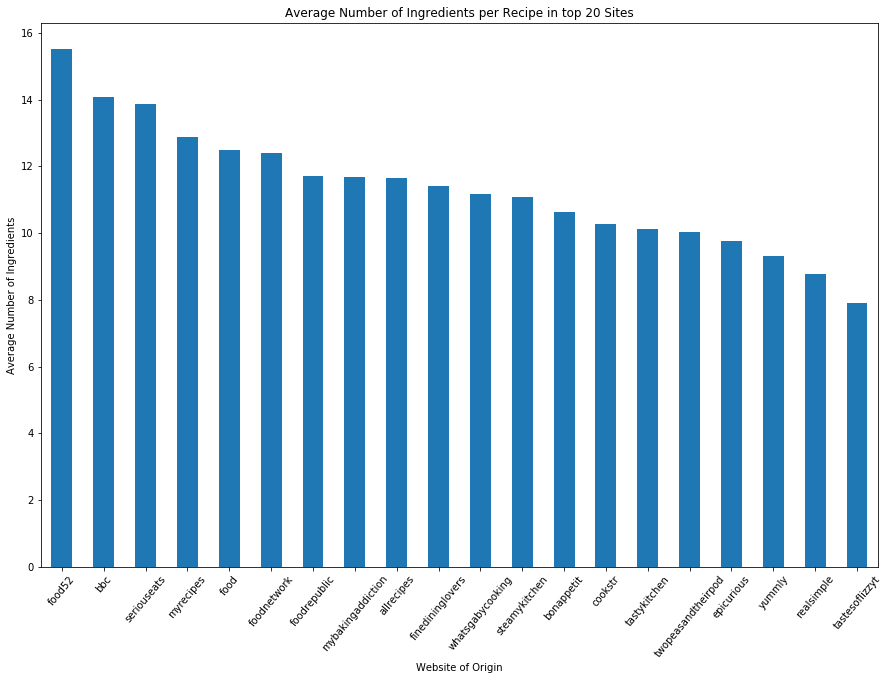

In [8]:
plt.figure(figsize=(15,10))
wb_topsum.AveNumIngr.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Average Number of Ingredients per Recipe in top 20 Sites')
plt.xlabel("Website of Origin")
plt.ylabel("Average Number of Ingredients")
plt.show()

In [9]:
#Read in 
ingredients = pd.read_csv('ingredients_agg.csv', names = ['Title','AggIngredients'], sep = ",", quotechar = '"', skipinitialspace=True, error_bad_lines = False, dtype=object)

In [10]:
#Cleanup separate commas, all lowercase, stem select words
ingredients.Title = ingredients.Title.str.replace(',',' , ')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace(',',' , ')
ingredients.Title = ingredients.Title.str.replace('(',' ')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('(',' ')
ingredients.Title = ingredients.Title.str.replace(')',' ')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace(')',' ')

ingredients.Title = ingredients.Title.str.lower()
ingredients.AggIngredients = ingredients.AggIngredients.str.lower()

ingredients.Title = ingredients.Title.str.replace('potatoes','potato')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('potatoes','potato')
ingredients.Title = ingredients.Title.str.replace('potatoes','potato')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('tomatoes','tomato')
ingredients.Title = ingredients.Title.str.replace('eggs','egg')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('eggs','egg')
#regex? clove * garlic, garlic clove
ingredients.Title = ingredients.Title.str.replace('garlic clove','garlic')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('garlic clove','garlic')
ingredients.Title = ingredients.Title.str.replace('cloves of garlic','garlic')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('cloves of garlic','garlic')
ingredients.Title = ingredients.Title.str.replace('clove of garlic','garlic')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('clove of garlic','garlic')

#!?


In [11]:
ingredients.AggIngredients.head()

Website                                                 aggingredients
100daysofrealfood    1½ pounds potato  ,  ,  1 1/2 pounds potato su...
101cookbooks         toasted sesame oil ,  1 cup whole coconut milk...
101cookingfortwo     2 pounds of skinless boneless chicken breast  ...
12tomatoes           1/2 onion ,  diced ,  3/4 cup plain greek yogu...
Name: AggIngredients, dtype: object

In [12]:
wordfreq_Title = ingredients.Title.apply(lambda x: pd.value_counts(str(x).split(" "))).sum(axis = 0)

In [13]:
wordfreq_Title = wordfreq_Title[3:]

In [14]:
wordfreq_AggIng = ingredients.AggIngredients.apply(lambda x: pd.value_counts(str(x).split(" "))).sum(axis = 0)

In [15]:
wordfreq_AggIng = wordfreq_AggIng[4:]

<Figure size 1080x720 with 0 Axes>

(array([    0,     1,     2, ..., 25062, 25063, 25064]),
 <a list of 25065 Text xticklabel objects>)

Text(0.5, 1.0, 'Word Frequency in Recipe Titles')

Text(0.5, 0, 'Word')

Text(0, 0.5, 'Frequency')

(0.0, 1000)

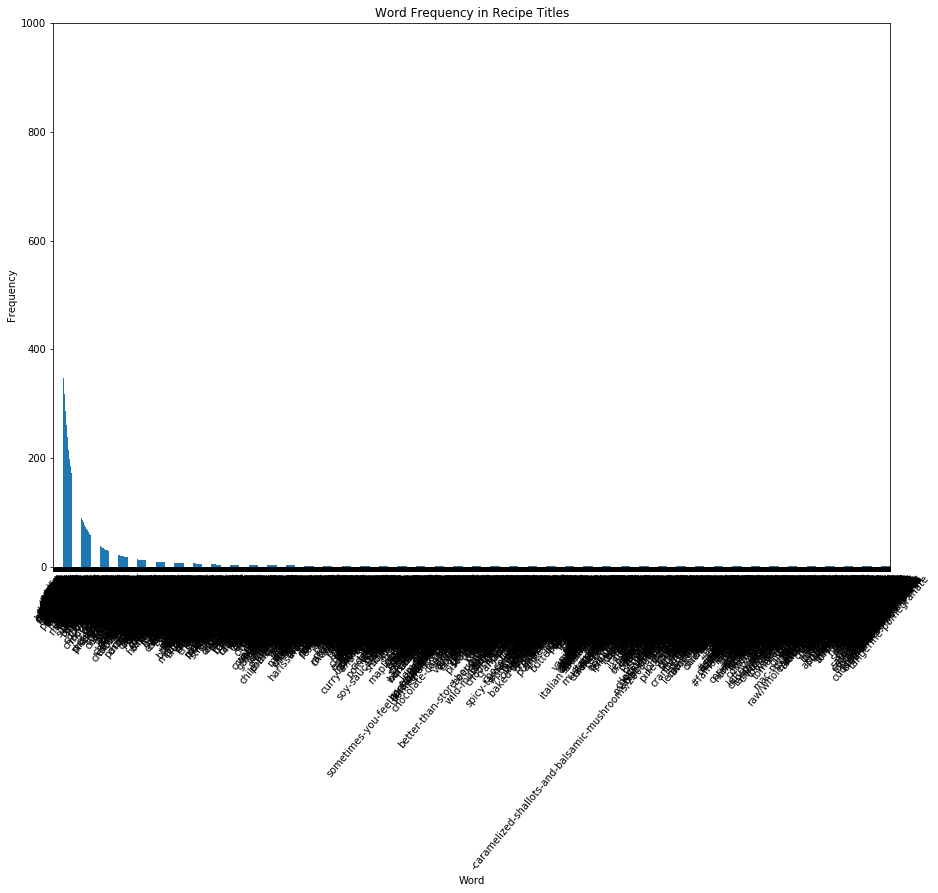

In [54]:
#View word count on Recipe Title
plt.figure(figsize=(15,10))
wordfreq_Title.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency in Recipe Titles')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.ylim(top = 1000)
plt.show()


Ridiculous, the code takes a long time and the resulting graph is not very readable due to a large number of datapoints.  Let's look at a smaller data set.

In [19]:
wordfreq_Title_top = wordfreq_Title.sort_values(ascending=False).head(50)
wordfreq_Title_top

with          34490.0
and           29750.0
chicken       10901.0
chocolate      6861.0
sauce          6502.0
salad          6159.0
cream          4526.0
cheese         4353.0
potato         4260.0
cake           4230.0
cookies        3760.0
grilled        3689.0
butter         3658.0
roasted        3542.0
pork           3318.0
pie            3045.0
lemon          2978.0
beef           2904.0
bread          2821.0
recipe         2558.0
red            2518.0
shrimp         2475.0
apple          2468.0
soup           2456.0
rice           2402.0
tomato         2366.0
&              2363.0
sweet          2208.0
pumpkin        2145.0
baked          2119.0
green          2037.0
spicy          1926.0
in             1923.0
peanut         1919.0
egg            1846.0
garlic         1840.0
coconut        1829.0
bacon          1787.0
lamb           1726.0
white          1716.0
banana         1686.0
salmon         1680.0
ice            1659.0
orange         1648.0
turkey         1624.0
strawberry

<Figure size 1080x720 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

Text(0.5, 1.0, 'Word Count of Recipe Titles per Site')

Text(0.5, 0, 'Word')

Text(0, 0.5, 'Frequency')

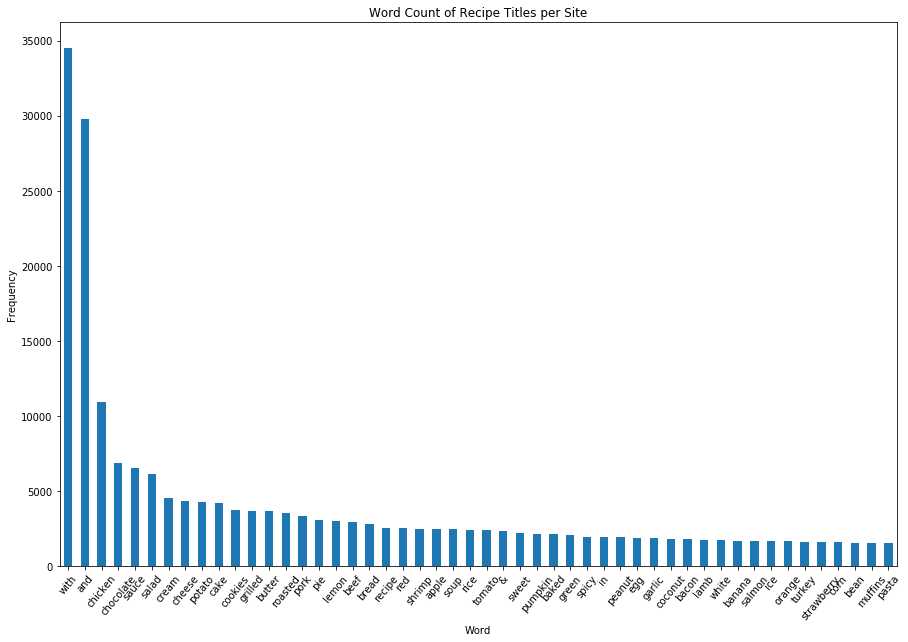

In [20]:
plt.figure(figsize=(15,10))
wordfreq_Title_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency in Recipe Titles')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

In [21]:
wordfreq_Ing_top = wordfreq_AggIng.sort_values(ascending=False).head(50)
wordfreq_Ing_top

1              438246.0
2              242633.0
cup            225307.0
cups           156501.0
tablespoons    138902.0
teaspoon       135479.0
1/2            125736.0
chopped        105824.0
salt           100182.0
teaspoons       86192.0
and             82910.0
3               80742.0
fresh           80232.0
½               77353.0
oil             74844.0
tablespoon      74283.0
pepper          73183.0
or              72234.0
sugar           70703.0
1/4             67256.0
4               63971.0
ground          62471.0
butter          55361.0
for             52762.0
whole           51564.0
large           47858.0
¼               44255.0
egg             43727.0
olive           43489.0
sliced          42006.0
flour           41297.0
into            40906.0
ounces          39792.0
cut             39316.0
black           37469.0
to              36540.0
finely          34081.0
juice           33348.0
red             33175.0
garlic          32566.0
freshly         31905.0
cream           

<Figure size 1080x720 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

Text(0.5, 0, 'Word')

Text(0, 0.5, 'Frequency')

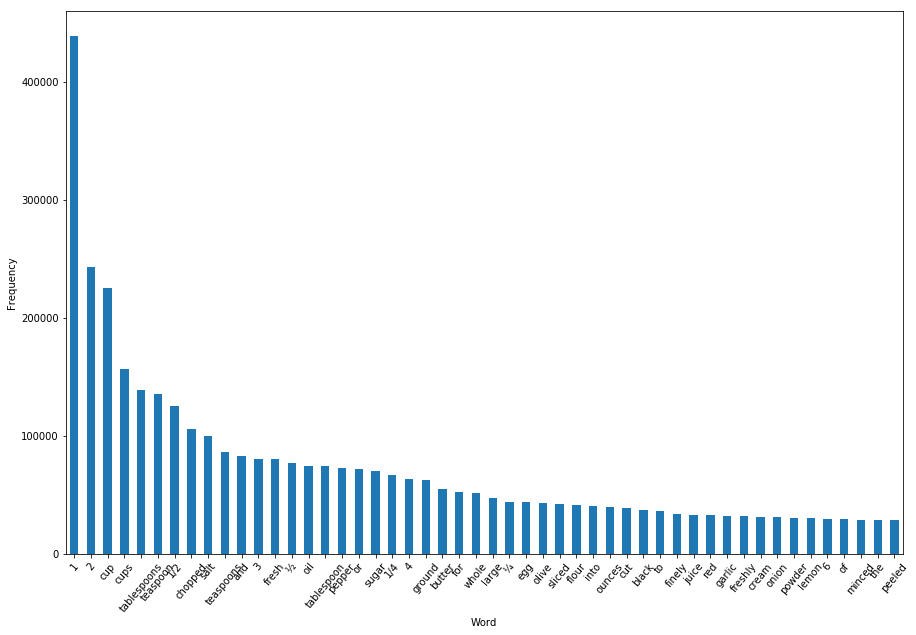

In [22]:
plt.figure(figsize=(15,10))
wordfreq_Ing_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency in Recipe Ingredients')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

There's a lot of high frequency, irrelevant words.  Remove the stopwords.  In a future version of this, all verbs would be removed as a collective.

In [23]:
# Create stopword list:
stopwords = set(STOPWORDS)
stop1 = ['a', 'and', 'the', 'or', 'of', 'if', 'on', 'but','with','®',
        'pinch', 'left', 'peeled', 'cut', 'chopped', 'sliced','&',
        'small', 'medium', 'large', 'whole', 'into', 'in', 'to',
        'plus', 'more', 'thick', 'halved', 'quartered', 'good',
        'inch', 'inches', 'about', 'sea', 'end', 'approximate',
        'approximately', 'very', 'finely', 'for', 'nan', 'none', 
         'recipe', 'freshly','ground']
measurement = ['teaspoon', 'tsp', 'tablespoon', 'tbsp','sprigs','sprig',
               'teaspoons', 'tablespoons', 
                'ounce', 'oz', 'cup', 'pint', 'pt', 
                'ounces', 'cups', 'pints',
                'quart', 'qt', 'gallon', 'gal',
                'quarts', 'gallons',
               'pound', 'lb', 'gram', 'kilogram',
               'pounds', 'lbs', 'grams', 'kilograms',
                'milliliter', 'liter', 'weight',
                'milliliters', 'liters']
amounts = ["1", "one", "2", "two", "3", 'three','4','four',
           '5','five','6','six','7','seven','8','eight','9',
           'nine','10','ten','½', '1/2','half', '1½','¼','1/4','3/4','⅓','1/3','¾','1-½','12']
stopwords.update(stop1,measurement,amounts)

In [24]:
#Remove stopwords 
wordfreq_AggIng = wordfreq_AggIng[~wordfreq_AggIng.index.isin(stopwords)]
wordfreq_Title = wordfreq_Title[~wordfreq_Title.index.isin(stopwords)]

In [25]:
wordfreq_Title_top = wordfreq_Title.sort_values(ascending=False).head(50)
wordfreq_Title_top
wordfreq_Ing_top = wordfreq_AggIng.sort_values(ascending=False).head(50)
wordfreq_Ing_top

chicken       10901.0
chocolate      6861.0
sauce          6502.0
salad          6159.0
cream          4526.0
cheese         4353.0
potato         4260.0
cake           4230.0
cookies        3760.0
grilled        3689.0
butter         3658.0
roasted        3542.0
pork           3318.0
pie            3045.0
lemon          2978.0
beef           2904.0
bread          2821.0
red            2518.0
shrimp         2475.0
apple          2468.0
soup           2456.0
rice           2402.0
tomato         2366.0
sweet          2208.0
pumpkin        2145.0
baked          2119.0
green          2037.0
spicy          1926.0
peanut         1919.0
egg            1846.0
garlic         1840.0
coconut        1829.0
bacon          1787.0
lamb           1726.0
white          1716.0
banana         1686.0
salmon         1680.0
ice            1659.0
orange         1648.0
turkey         1624.0
strawberry     1623.0
corn           1610.0
bean           1562.0
muffins        1556.0
pasta          1549.0
salsa     

salt           100182.0
fresh           80232.0
oil             74844.0
pepper          73183.0
sugar           70703.0
butter          55361.0
egg             43727.0
olive           43489.0
flour           41297.0
black           37469.0
juice           33348.0
red             33175.0
garlic          32566.0
cream           31758.0
onion           31042.0
powder          30507.0
lemon           30210.0
minced          29036.0
cheese          28436.0
water           28183.0
white           27426.0
vanilla         26729.0
grated          26123.0
kosher          25999.0
unsalted        25805.0
chicken         25640.0
leaves          25462.0
sauce           25085.0
milk            24673.0
tomato          23934.0
baking          22860.0
dried           21262.0
diced           21122.0
thinly          18624.0
extract         18605.0
vinegar         18098.0
divided         17981.0
all-purpose     17941.0
vegetable       17690.0
brown           17689.0
pieces          17226.0
green           

With a large set of stopwords removed from the analysis, the graphs are more relevant.

<Figure size 1080x720 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

Text(0.5, 1.0, 'Word Count of Recipe Ingredients (w/o StopWords)')

Text(0.5, 0, 'Word')

Text(0, 0.5, 'Frequency')

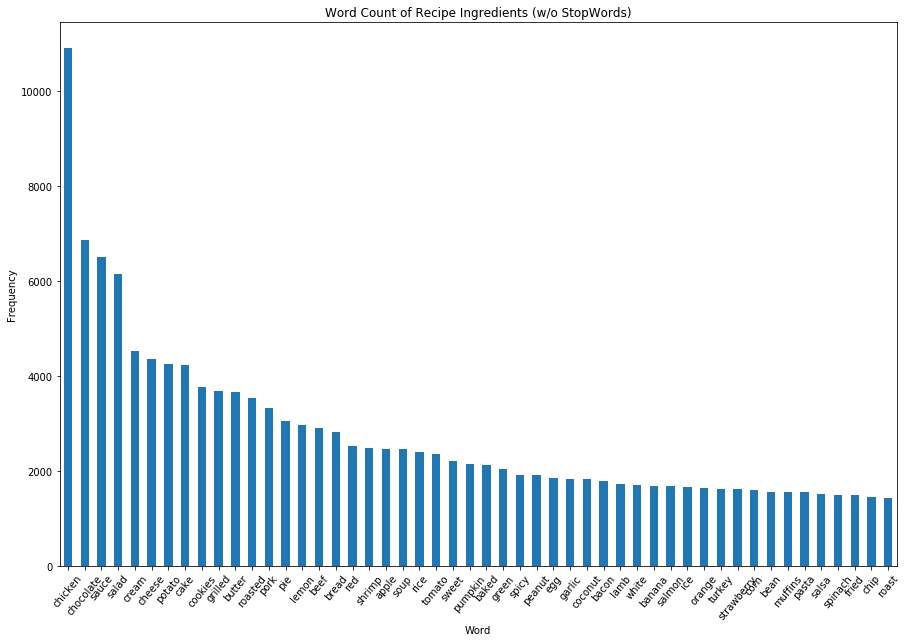

In [29]:
plt.figure(figsize=(15,10))
wordfreq_Title_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency in Recipe Title (w/o StopWords)')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

<Figure size 1080x720 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

Text(0.5, 1.0, 'Word Frequency of Recipe Ingredients (w/o StopWords)')

Text(0.5, 0, 'Word')

Text(0, 0.5, 'Frequency')

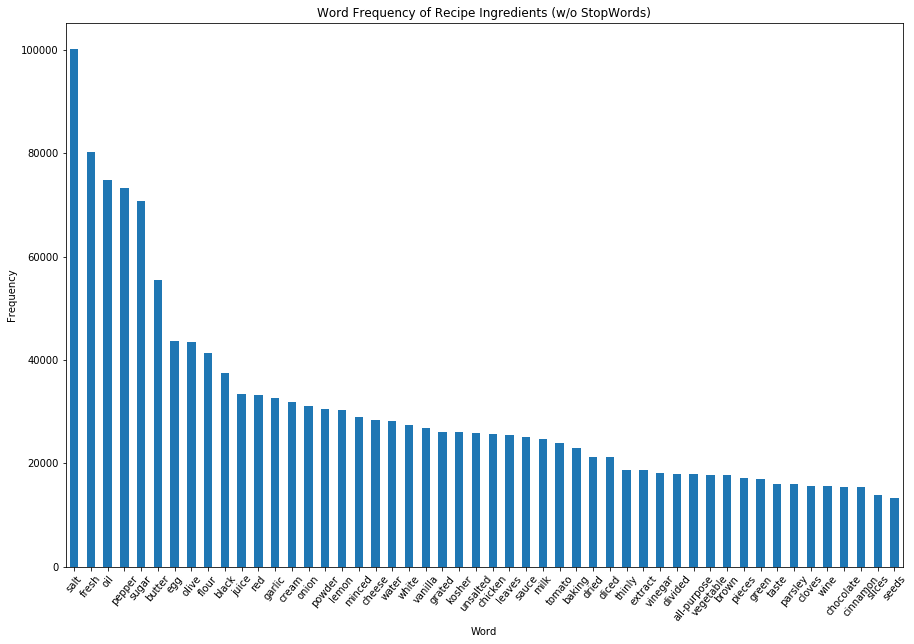

In [30]:
plt.figure(figsize=(15,10))
wordfreq_Ing_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency of Recipe Ingredients (w/o StopWords)')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

Looking through the x-axis, there are several more stopwords which could be added if one wanted to see only ingredients.  The following updated list causes several false correlations, such as bell pepper and black pepper.  In future iterations of this project, the concept of bigrams would be explored to get more accurate analysis.

In [31]:
#Remove adj and verbs
stopwordsExtra = stopwords.copy()
stopwordsExtra.update(['fresh','black','red','powder','minced','white',
                       'grated','kosher','unsalted','leaves','sauce','baking',
                      'dried','diced','thinly','extract','divided','brown','pieces',
                      'green','taste','slices','seeds','dry','room','temperature',
                      'all-purpose','shredded','crushed','drained','coarsely',
                      'heavy','frozen','granulated','melted','softened','trimmed',
                       'toasted','yellow','removed','cubes','cooked','light','seeded','powdered'])

In [32]:
wordfreq_AggIng = wordfreq_AggIng[~wordfreq_AggIng.index.isin(stopwordsExtra)]
wordfreq_Ing_top = wordfreq_AggIng.sort_values(ascending=False).head(50)
wordfreq_Ing_top

salt            100182.0
oil              74844.0
pepper           73183.0
sugar            70703.0
butter           55361.0
egg              43727.0
olive            43489.0
flour            41297.0
juice            33348.0
garlic           32566.0
cream            31758.0
onion            31042.0
lemon            30210.0
cheese           28436.0
water            28183.0
vanilla          26729.0
chicken          25640.0
milk             24673.0
tomato           23934.0
vinegar          18098.0
vegetable        17690.0
parsley          15897.0
cloves           15666.0
wine             15647.0
chocolate        15338.0
cinnamon         15315.0
garlics          12821.0
ginger           12632.0
lime             12401.0
onions           12092.0
rice             11307.0
cilantro         10956.0
broth            10587.0
potato           10503.0
thyme            10407.0
soda             10326.0
orange           10295.0
extra-virgin     10205.0
beef              9996.0
coconut           9604.0


<Figure size 1080x720 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

Text(0.5, 1.0, 'Word Frequency of Recipe Ingredients (w/o Extra StopWords)')

Text(0.5, 0, 'Ingredient')

Text(0, 0.5, 'Frequency')

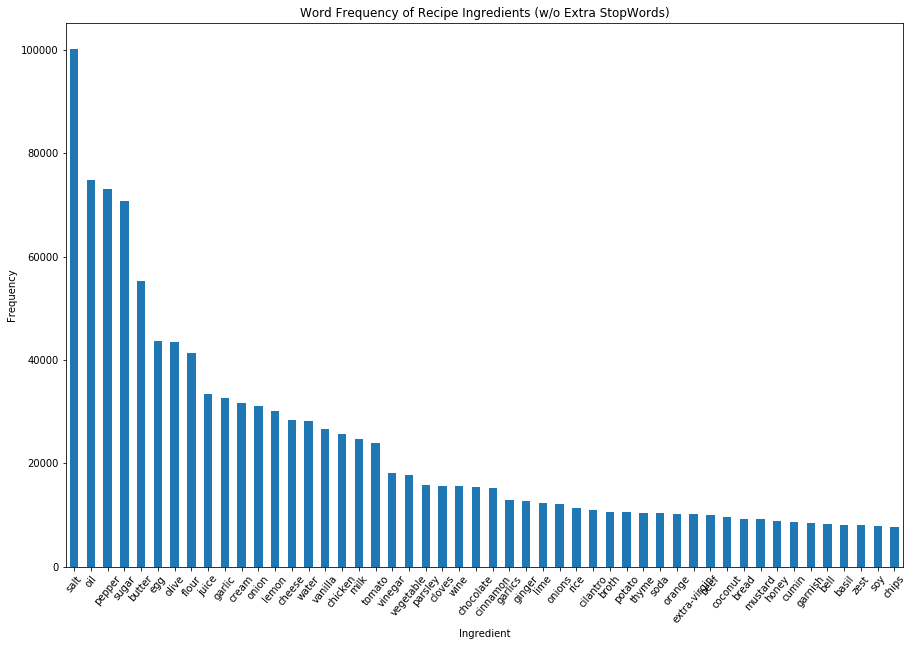

In [34]:
plt.figure(figsize=(15,10))
wordfreq_Ing_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency of Recipe Ingredients (w/o Extra StopWords)')
plt.xlabel("Ingredient")
plt.ylabel("Frequency")
plt.show()

It may be interesting to view the above graph of ingredient frequencies as a proportion over the total number of recipes.  For example, salt is an ingredient in about 75% of the scraped recipes.

In [37]:
wordfreq_Ing_prop = wordfreq_AggIng.sort_values(ascending=False).head(50)/len(df)
wordfreq_Ing_prop.head(5)

salt      0.749596
oil       0.560008
pepper    0.547580
sugar     0.529024
butter    0.414230
dtype: float64

<Figure size 1080x720 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

Text(0.5, 1.0, 'Proportion of Recipes containing given Ingredient')

Text(0.5, 0, 'Word')

Text(0, 0.5, 'Proportion')

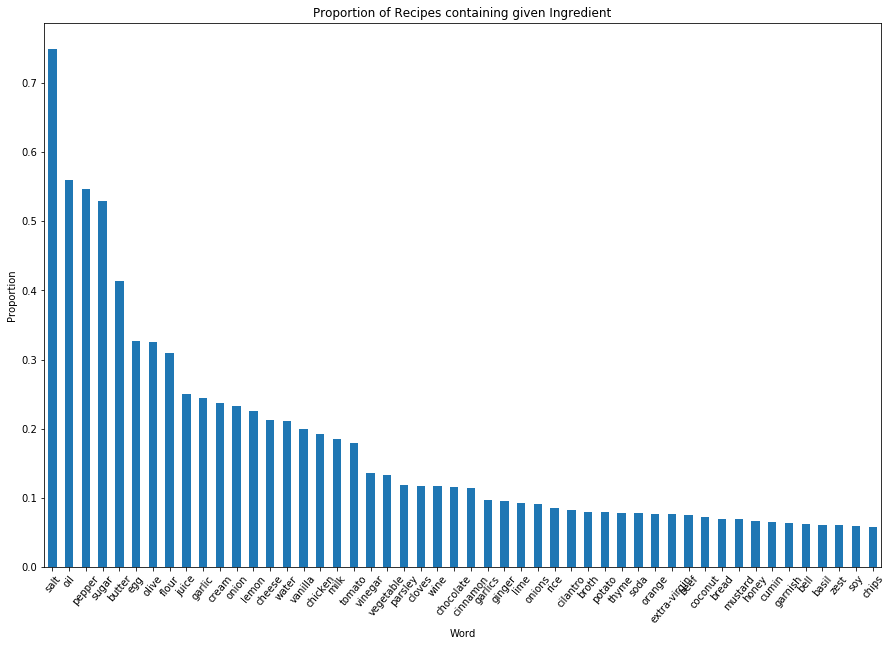

In [39]:
plt.figure(figsize=(15,10))
wordfreq_Ing_prop.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Proportion of Recipes containing given Ingredient')
plt.xlabel("Word")
plt.ylabel("Proportion")
plt.show()

In [40]:
def wc(site,section, pic=None):
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white",mask=pic).generate(ingredients.loc[site,section])
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [41]:
food_mask = np.array(Image.open("Img/CoveredHotPlate.jpg"))
food_mask

chicken_mask = np.array(Image.open("Img/Chicken.jpg"))
chicken_mask

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [ 85,  85,  85],
        [  5,   5,   5],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [244, 244, 244],
        [ 96,  96,  96],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[250, 250, 250],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [46]:
#swap number 0 to 255
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [47]:
#Sometimes the mask needs to be transformed?
#Transform your mask into a new one that will work with the function:
chicken_mask_trans = np.ndarray((chicken_mask.shape[0],chicken_mask.shape[1]), np.int32)

for i in range(len(chicken_mask)):
    for j in range(len(chicken_mask[i])):
        chicken_mask_trans[i][j] = list(map(transform_format, chicken_mask[i][j]))

ValueError: setting an array element with a sequence.

In [ ]:
wb_topsum

In [ ]:
wc('tastykitchen','Title')

In [ ]:
wc('tastykitchen','AggIngredients')

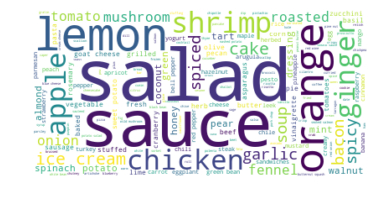

In [42]:
wc('epicurious','Title')

In [ ]:
wc('epicurious','AggIngredients')

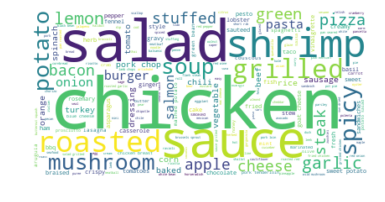

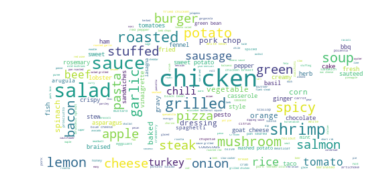

In [49]:
wc('foodnetwork','Title')
# wc('foodnetwork','Title', pic = chicken_mask)

In [ ]:
wc('foodnetwork','AggIngredients')

In [ ]:
wc('bonappetit','Title')

In [ ]:
wc('bonappetit','AggIngredients')

In [ ]:
wc('bonappetit','Title',food_mask)

In [ ]:
wc('cookstr','Title')

In [ ]:
wc('cookstr', 'AggIngredients')

In [ ]:
ingredients['Title'].str.cat()

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(ingredients['Title'].str.cat())
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(ingredients['AggIngredients'].str.cat())
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This dataset started its life on a various recipe database websites.  Through webscraper code, utilizing BeautifulSoup and open source code as a base, the initial csv of 155,876 lines listed the url, recipe title, total time, and each ingredient as a separate column.  Recipe titles or ingredients which internally contained commas were surrounded by double quotes.

The recipe scraper provides ingredients as they are written within the websites. We will need to parse out the amounts from the ingredients themselves and occasionally additional instructions. (1 10-oz. package frozen blackberries (about 2 cups), thawed) (2 large fresh fennel bulbs, trimmed, each cut vertically into 12 wedges with some core attached) The amounts and the ingredients will need to be normalized to merge with the nutritional dataset.